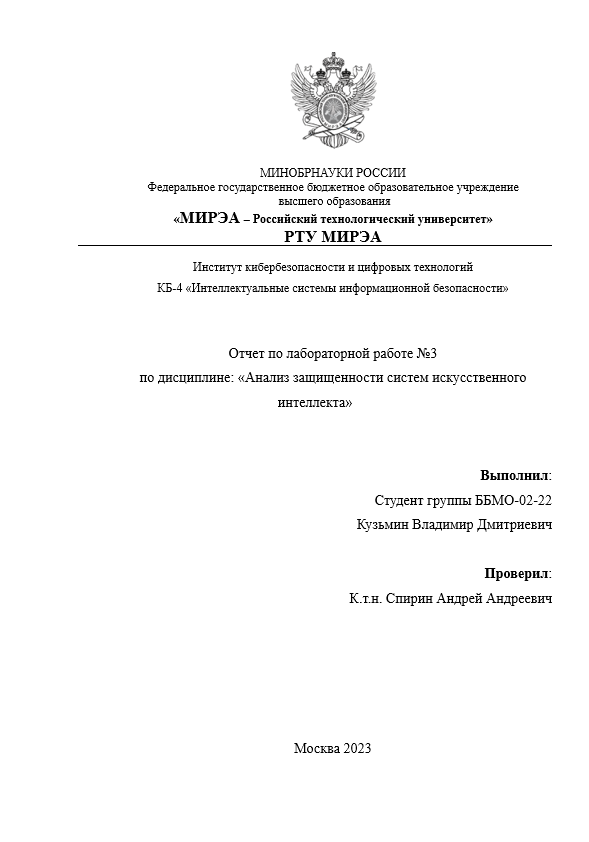

In [ ]:
!pip install tf-keras-vis

In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


### Загрузим модель

Использовать будем модель VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Загрузим и предобработаем изображения

tf-keras-vis поддерживает пакетную визуализацию. Здесь, мы загружаем и предобрабатываем четыре изображения: муху, пчелу, муравья и хомякa.



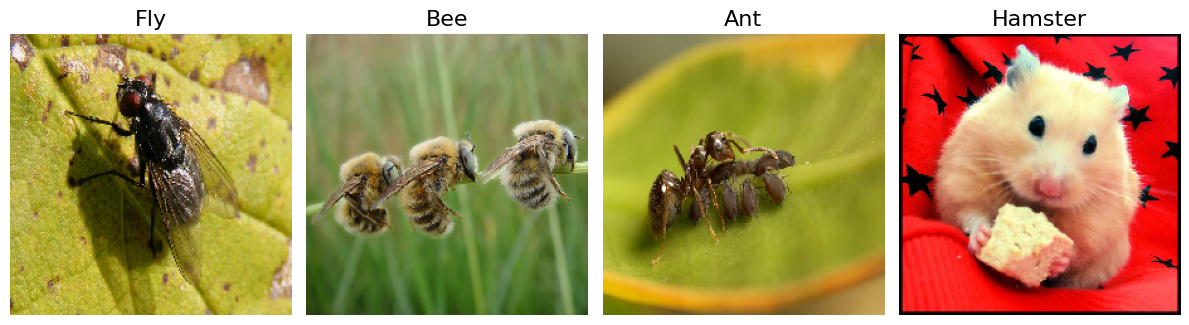

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

# Заголовки для изображений
image_titles = ['Fly', 'Bee', 'Ant', 'Hamster']

# Загружаем изображения и конвертируем их в массив Numpy
img1 = load_img('fly.JPEG', target_size=(224, 224))
img2 = load_img('bee.JPEG', target_size=(224, 224))
img3 = load_img('ant.JPEG', target_size=(224, 224))
img4 = load_img('hamster.JPEG', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4)])

# Подготавливаем входы для VGG16
X = preprocess_input(images)

# Отрисуем
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Реализация функций, необходимых для использования внимания
### Модификатор модели

Когда функция активации softmax применяется к последнему слою модели, это может препятствовать созданию изображений внимания, поэтому нам следует заменить эту функцию на функцию линейной активации. Хотя здесь мы создаем и используем экземпляр `ReplaceToLinear`, мы также можем использовать функцию модификатора модели, определенную нами.

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Вместо использования экземпляра replaceToLinear, описанного выше,
# мы можем определить функцию с нуля следующим образом:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

### Функция расчета

Здесь мы создаем экземпляр `Score` или определяем `score function`, которая возвращает целевые баллы. Здесь они возвращают количество очков, соответствующее мухе, пчеле, муравью и хомяку.

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore

# 308 - муха, 309 - пчела, 310 - муравей и 333 - хомяк.
score = CategoricalScore([308, 309, 310, 333])

# Вместо использования объекта CategoricalScore
# мы можем определить функцию с нуля следующим образом:
def score_function(output):
    # Переменная `output` ссылается на выходы модели,
    # таким образом, что размерность `output` равна `(3, 1000)` где, (номер примера, номер класса).
    return (output[0][308], output[1][309], output[2][310], output[3][333])

## Ванильное внимание

`Saliency` генерирует карту внимания, подсвечивая области входного изображения, имеющие наибольшее влияние на выходное значение.

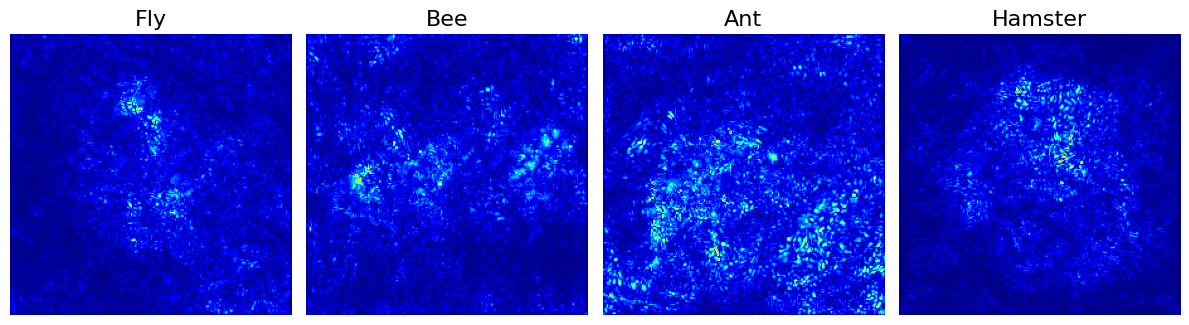

CPU times: user 5.58 s, sys: 1.71 s, total: 7.29 s
Wall time: 15.4 s


In [ ]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Создаем объект внимания
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Генерируем карту внимания
saliency_map = saliency(score, X)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Отрисуем
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## SmoothGrad

Как мы можем видеть выше, карта ванильной значимости слишком шумная, поэтому давайте удалим шум на карте значимости с помощью SmoothGrad! SmoothGrad — это метод, который уменьшает шум на карте значимости путем добавления шума к входному изображению.

**Примечание.** Поскольку SmoothGrad вычисляет градиент неоднократно, при использовании ЦП это может занять много времени (около 2–3 минут).

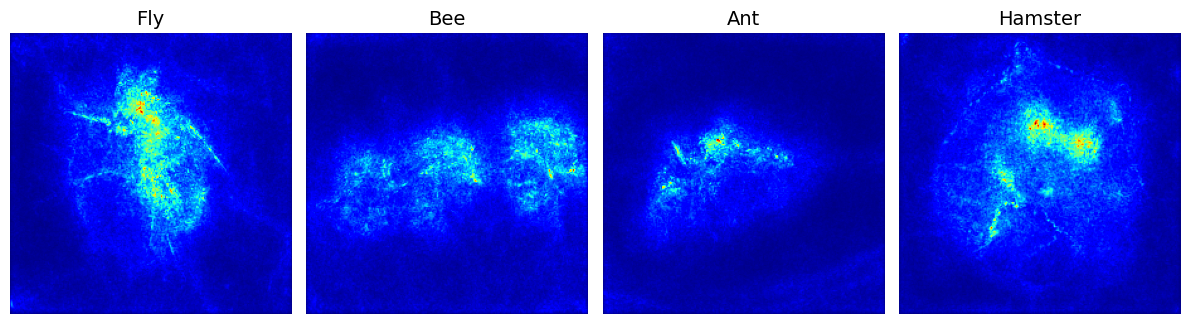

CPU times: user 2.13 s, sys: 244 ms, total: 2.37 s
Wall time: 3.51 s


In [ ]:
%%time

# Генерируем карту внимания со сглаживанием, которое уменьшает шум за счет добавления шума
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # Количество итераций расчета градиентов.
                        smooth_noise=0.20) # уровень распространения шума.

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Отрисуем
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('smoothgrad.png')
plt.show()

## GradCAM

Выраженность — это один из полезных способов визуализации внимания, которое проявляется в тех областях входного изображения, которые в наибольшей степени способствуют выходному значению.
GradCAM — это еще один способ визуализировать внимание к вводу. Вместо использования градиентов выходных данных модели он использует выходные данные предпоследнего слоя (то есть сверточного слоя непосредственно перед плотными слоями).

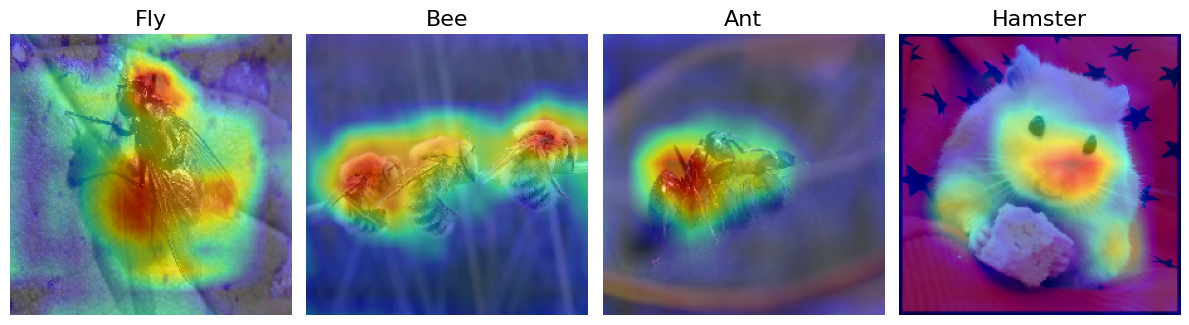

CPU times: user 1.51 s, sys: 780 ms, total: 2.28 s
Wall time: 2.16 s


In [ ]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Создаем объект Gradcam
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Генерируем тепловую карту с GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Отрисуем
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

Как мы можем видеть выше, GradCAM — полезный метод интуитивного определения того, на чем находится внимание. Однако, если мы присмотримся, то увидим, что отображаемое внимание не полностью покрывает цель на картинке.

Хорошо, тогда давайте перейдем к следующему методу, который может решить проблему, которую мы рассмотрели выше.

## GradCAM++

GradCAM++ может обеспечить лучшее визуальное объяснение прогнозов модели CNN.

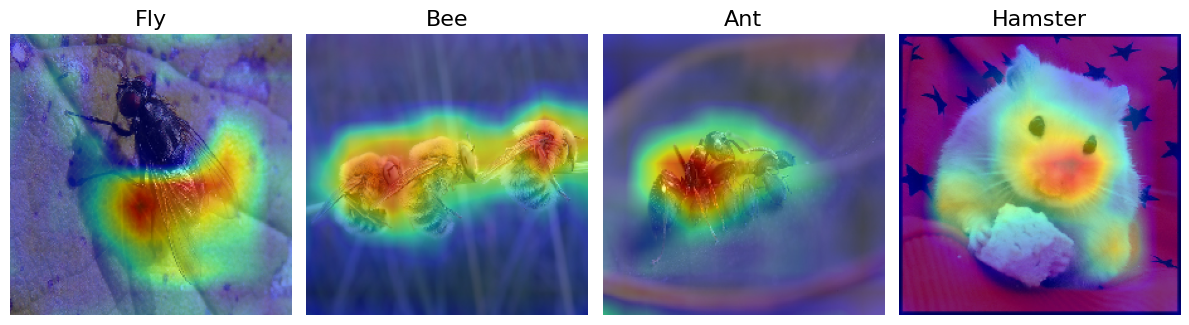

CPU times: user 1.94 s, sys: 743 ms, total: 2.68 s
Wall time: 2.6 s


In [ ]:
%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Создаем объект GradCAM++
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

# Генерируем тепловую карту с помощью GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Отрисуем
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('gradcam_plus_plus.png')
plt.show()